In [1]:
import sys
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py
import scipy.stats as ss
from statsmodels.stats.multitest import multipletests
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

sys.path.insert(0, '../CODE/')
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
HM_COLORS = {
    'H3K27ac': COLORS['dark_blue'],
    'H3K27me3': COLORS['dark_green'],
    'H3K36me3': COLORS['light_blue'],
    'H3K4me1': COLORS['yellow'],
    'H3K4me3': COLORS['red'],
    'H3K79me1': '#842bd7',
    'H3K9me3': COLORS['grey'],
    'H4K16ac': COLORS['dark_red']
}

# Yeast histone marks: load data

In [3]:
organism = 'yeast'
feat_type = 'histone_modifications'
feat_names = [
    'h3k27ac_tp1_0_merged', 
    'h3k36me3_tp1_0_merged', 
    'h3k4me3_tp1_0_merged', 
    'h3k4me_tp1_0_merged', 
    'h3k79me_tp1_0_merged', 
    'h4k16ac_tp1_0_merged'
]

cc_perm_df = pd.read_csv('tables/SupplementalTable_CallingCards.csv')
cc_tfs = cc_perm_df.loc[cc_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

chipexo_perm_df = pd.read_csv('tables/SupplementalTable_ChIP-exo.csv')
chipexo_tfs = chipexo_perm_df.loc[chipexo_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

hm_shap_df = pd.DataFrame()

for feat_name in feat_names:
    print('Working on', feat_name)
    
    # Calling cards
    hm_shap_subdf = link_shap_to_coord_feats(
        feat_type, cc_tfs,
        '../OUTPUT/yeast_cc/all_feats/',
        '../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv',
        feat_name=feat_name,
        coord_offset=1000, bin_width=100
    )
    hm_shap_subdf['assay_type'] = 'Calling Cards'
    hm_shap_subdf['feat_name'] = FEATURE_NAME_DICT[organism][feat_type + ':' + feat_name]
    hm_shap_df = hm_shap_df.append(hm_shap_subdf, ignore_index=True)
    
    # ChIP-exo
    hm_shap_subdf = link_shap_to_coord_feats(
        feat_type, chipexo_tfs,
        '../OUTPUT/yeast_chipexo/all_feats/',
        '../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv',
        feat_name=feat_name,
        coord_offset=1000, bin_width=100
    )
    hm_shap_subdf['assay_type'] = 'ChIP-exo'
    hm_shap_subdf['feat_name'] = FEATURE_NAME_DICT[organism][feat_type + ':' + feat_name]
    hm_shap_df = hm_shap_df.append(hm_shap_subdf, ignore_index=True)

Working on h3k27ac_tp1_0_merged
Loading feature data ... 0 1 
Loading feature data ... 0 1 
Working on h3k36me3_tp1_0_merged
Loading feature data ... 0 1 
Loading feature data ... 0 1 
Working on h3k4me3_tp1_0_merged
Loading feature data ... 0 1 
Loading feature data ... 0 1 
Working on h3k4me_tp1_0_merged
Loading feature data ... 0 1 
Loading feature data ... 0 1 
Working on h3k79me_tp1_0_merged
Loading feature data ... 0 1 
Loading feature data ... 0 1 
Working on h4k16ac_tp1_0_merged
Loading feature data ... 0 1 
Loading feature data ... 0 1 


# Yeast histone marks: global importance
- For each TF, the global importance of each feature is the absolute SHAP value for that feature averaged across all genes and all promoter bins upstream or downstream of the TSS. 

In [4]:
hm_shap_df['abs_shap'] = hm_shap_df['shap'].abs()
hm_shap_df['is_upstream'] = hm_shap_df['coord'].apply(lambda x: True if x < 0 else False)

global_imp_df = hm_shap_df.groupby(
    ['assay_type', 'feat_name', 'is_upstream', 'tf']
)[['abs_shap']].mean().reset_index()
global_imp_df['up_down_region'] = global_imp_df['is_upstream'].apply(lambda x: 'Upstream' if x else 'Downstream')

global_imp_df.to_csv('helper_data/yeast_hm_global_imp_df.csv.gz', index=False)

H4K16ac: t-test p=0.004, Wilcoxon p=0.000
H3K79me1: t-test p=0.000, Wilcoxon p=0.000
H3K4me3: t-test p=0.000, Wilcoxon p=0.000
H3K4me1: t-test p=0.000, Wilcoxon p=0.000
H3K36me3: t-test p=0.000, Wilcoxon p=0.000
H3K27ac: t-test p=0.002, Wilcoxon p=0.000


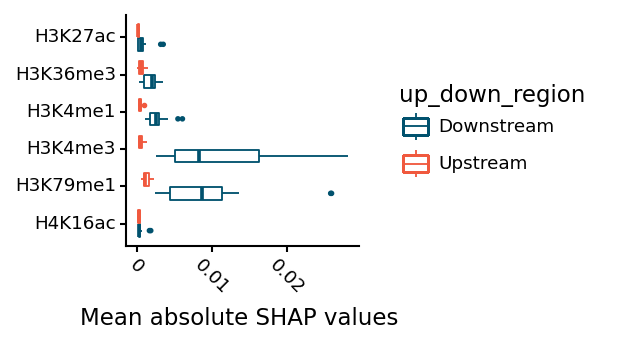

<ggplot: (-9223369058356080808)>

In [5]:
# global_imp_df = pd.read_csv('helper_data/yeast_hm_global_imp_df.csv.gz')

global_imp_df['feat_name'] = pd.Categorical(global_imp_df['feat_name'], ordered=True, categories=sorted(global_imp_df['feat_name'].unique())[::-1])
global_imp_df['up_down_region'] = pd.Categorical(global_imp_df['up_down_region'], ordered=True, categories=['Downstream', 'Upstream'])

for hm, subdf in global_imp_df.groupby('feat_name'):
    _, t_p = ss.ttest_rel(
        subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
        subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
    _, w_p = ss.wilcoxon(
        subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
        subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
    print('{}: t-test p={:.3f}, Wilcoxon p={:.3f}'.format(hm, t_p, w_p))

ax = (
    ggplot(global_imp_df, aes(x='feat_name', y='abs_shap', color='up_down_region'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + coord_flip()
    + labs(x=None, y='Mean absolute SHAP values')
#     + ylim(0, .06)
    + theme_classic()
    + theme(
        figure_size=(2, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

# ax.save('figures/Yeast_hm_global_imp_vs_up_down_region.pdf')

Calling Cards
H4K16ac: t-test p=0.078, Wilcoxon p=0.035
H3K79me1: t-test p=0.000, Wilcoxon p=0.000
H3K4me3: t-test p=0.000, Wilcoxon p=0.000
H3K4me1: t-test p=0.000, Wilcoxon p=0.000
H3K36me3: t-test p=0.000, Wilcoxon p=0.000
H3K27ac: t-test p=0.003, Wilcoxon p=0.000
ChIP-exo
H4K16ac: t-test p=0.000, Wilcoxon p=0.000
H3K79me1: t-test p=0.000, Wilcoxon p=0.000
H3K4me3: t-test p=0.000, Wilcoxon p=0.000
H3K4me1: t-test p=0.000, Wilcoxon p=0.000
H3K36me3: t-test p=0.135, Wilcoxon p=0.204
H3K27ac: t-test p=0.107, Wilcoxon p=0.092


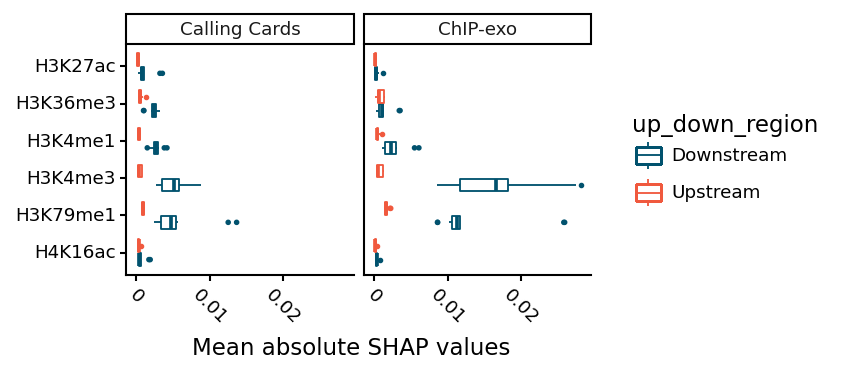

<ggplot: (-9223369058434188670)>

In [6]:
for assay_type in ['Calling Cards', 'ChIP-exo']:
    print(assay_type)
    for hm, subdf in global_imp_df[global_imp_df['assay_type'] == assay_type].groupby('feat_name'):
        _, t_p = ss.ttest_rel(
            subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
            subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
        _, w_p = ss.wilcoxon(
            subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
            subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
        print('{}: t-test p={:.3f}, Wilcoxon p={:.3f}'.format(hm, t_p, w_p))

ax = (
    ggplot(global_imp_df, aes(x='feat_name', y='abs_shap', color='up_down_region'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + coord_flip()
    + labs(x=None, y='Mean absolute SHAP values')
#     + ylim(0, .06)
    + facet_wrap('assay_type')
    + theme_classic()
    + theme(
        figure_size=(4, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_hm_global_imp_vs_up_down_region.pdf')

# Yeast histone marks: SHAP vs input correlation

In [7]:
corr_df = hm_shap_df.groupby(
    ['assay_type', 'feat_name', 'coord', 'tf']
).apply(
    lambda x: ss.pearsonr(x['input'], x['shap'])[0]
).reset_index().rename(columns={0: 'r'})

corr_df.to_csv('helper_data/yeast_hm_corr_df.csv.gz', index=False)

In [8]:
# corr_df = pd.read_csv('helper_data/yeast_hm_corr_df.csv.gz')

corr_df['up_down_region'] = corr_df['coord'].apply(lambda x: 'Upstream' if x < 0 else 'Downstream')

# Take the mean across up/downstream bins for each TF
corr_df = corr_df.groupby(['feat_name', 'tf', 'up_down_region', 'assay_type'])[['r']].mean().reset_index()

corr_df['feat_name'] = pd.Categorical(corr_df['feat_name'], ordered=True, categories=sorted(corr_df['feat_name'].unique())[::-1])
corr_df['up_down_region'] = pd.Categorical(corr_df['up_down_region'], ordered=True, categories=['Downstream', 'Upstream'])

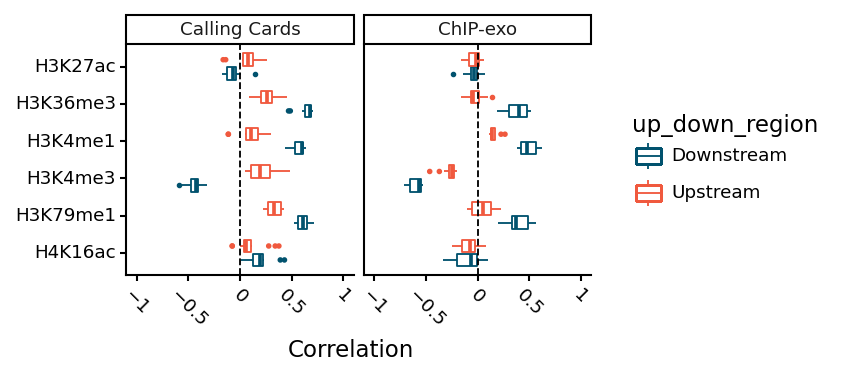

<ggplot: (2978439693916)>

In [9]:
ax = (
    ggplot(
        corr_df,
        aes(x='feat_name', y='r', color='up_down_region'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + geom_hline(aes(yintercept=0), linetype='dashed')
    + coord_flip()
    + facet_wrap('assay_type')
    + labs(x=None, y='Correlation')
    + ylim(-1, 1)
    + theme_classic()
    + theme(
        figure_size=(4, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_hm_shap_corr_mean.pdf')

---
# Human K562 histone marks: load data

In [20]:
organism = 'human_k562'
feat_type = 'histone_modifications'
feat_names = [
    'K562_H3K27ac',
    'K562_H3K27me3',
    'K562_H3K36me3',
    'K562_H3K4me1',
    'K562_H3K4me3',
    'K562_H3K9me3'
]

k562_perm_df = pd.read_csv('tables/SupplementalTable_K562.csv')
k562_tfs = k562_perm_df.loc[k562_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

h1_perm_df = pd.read_csv('tables/SupplementalTable_H1_TGI.csv')
h1_tfs = h1_perm_df.loc[h1_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

# hek293_perm_df = pd.read_csv('tables/SupplementalTable_')
# hek293_tfs = hek293_perm_df.loc[hek293_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])
hek293_tfs = np.loadtxt('../RESOURCES/TF_list/Human_HEK293_TFs.txt', dtype=str, usecols=[0])

hm_shap_df = pd.DataFrame()

for feat_name in feat_names:
    print('Working on', feat_name)
    
    hm_shap_subdf = link_shap_to_coord_feats(
        feat_type, k562_tfs,
        '../OUTPUT/human_k562/all_feats/',
        '../RESOURCES/Human_K562_TFPert/K562_pertResp_DESeq2_long.csv',
        is_resp_format_long=True,
        feat_name=feat_name,
        coord_offset=2000, bin_width=100
    )
    hm_shap_subdf['feat_name'] = FEATURE_NAME_DICT[organism][feat_type + ':' + feat_name]
    hm_shap_subdf = hm_shap_subdf[['feat_name', 'tf', 'coord', 'input', 'shap']]
    hm_shap_df = hm_shap_df.append(hm_shap_subdf, ignore_index=True)
    
hm_shap_df.loc[hm_shap_df['coord'] == 2000, 'coord'] = -9999
hm_shap_df.loc[hm_shap_df['coord'] == 2100, 'coord'] = 9999

Working on K562_H3K27ac
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Working on K562_H3K27me3
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Working on K562_H3K36me3
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Working on K562_H3K4me1
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Working on K562_H3K4me3
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Working on K562_H3K9me3
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 


# Human K562 histone marks: global importance

In [21]:
hm_shap_df['abs_shap'] = hm_shap_df['shap'].abs()
hm_shap_df['is_upstream'] = hm_shap_df['coord'].apply(lambda x: True if x < 0 else False)

global_imp_df = hm_shap_df.groupby(
    ['feat_name', 'is_upstream', 'tf']
)[['abs_shap']].mean().reset_index()
global_imp_df['up_down_region'] = global_imp_df['is_upstream'].apply(lambda x: 'Upstream' if x else 'Downstream')

global_imp_df.to_csv('helper_data/human_k562_hm_global_imp_df.csv.gz', index=False)

H3K9me3: t-test p=0.000, Wilcoxon p=0.000
H3K4me3: t-test p=0.000, Wilcoxon p=0.000
H3K4me1: t-test p=0.000, Wilcoxon p=0.000
H3K36me3: t-test p=0.000, Wilcoxon p=0.000
H3K27me3: t-test p=0.000, Wilcoxon p=0.000
H3K27ac: t-test p=0.000, Wilcoxon p=0.000


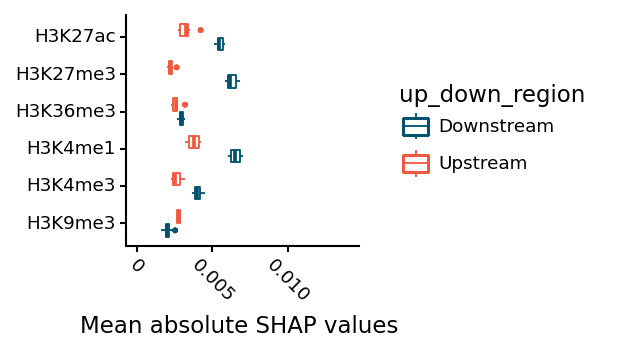

<ggplot: (-9223370578418516799)>

In [120]:
# global_imp_df = pd.read_csv('helper_data/human_k562_hm_global_imp_df.csv.gz')

global_imp_df['feat_name'] = pd.Categorical(global_imp_df['feat_name'], ordered=True, categories=sorted(global_imp_df['feat_name'].unique())[::-1])
global_imp_df['up_down_region'] = pd.Categorical(global_imp_df['up_down_region'], ordered=True, categories=['Downstream', 'Upstream'])

for hm, subdf in global_imp_df.groupby('feat_name'):
    _, t_p = ss.ttest_rel(
        subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
        subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
    _, w_p = ss.wilcoxon(
        subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
        subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
    print('{}: t-test p={:.3f}, Wilcoxon p={:.3f}'.format(hm, t_p, w_p))

ax = (
    ggplot(global_imp_df, aes(x='feat_name', y='abs_shap', color='up_down_region'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + coord_flip()
    + labs(x=None, y='Mean absolute SHAP values')
    + ylim(0, .014)
    + theme_classic()
    + theme(
        figure_size=(2, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_K562_hm_global_imp_vs_up_down_region.pdf')

# Human K562 histone marks: SHAP vs input correlation

In [23]:
corr_df = hm_shap_df.groupby(
    ['feat_name', 'coord', 'tf']
).apply(
    lambda x: ss.pearsonr(x['input'], x['shap'])[0]
).reset_index().rename(columns={0: 'r'})

corr_df.to_csv('helper_data/human_k562_hm_corr_df.csv.gz', index=False)

In [129]:
# corr_df = pd.read_csv('helper_data/human_k562_hm_corr_df.csv.gz')

corr_df['up_down_region'] = corr_df['coord'].apply(lambda x: 'Upstream' if x < 0 else 'Downstream')
corr_df['enhan_prom'] = corr_df['coord'].apply(lambda x: 'Enhancer' if x in [-9999, 9999] else 'Promoter')

# Take the mean across up/downstream bins for each TF
corr_df = corr_df.groupby(['feat_name', 'tf', 'up_down_region', 'enhan_prom'])[['r']].mean().reset_index()

corr_df['feat_name'] = pd.Categorical(corr_df['feat_name'], ordered=True, categories=sorted(corr_df['feat_name'].unique())[::-1])
corr_df['up_down_region'] = pd.Categorical(corr_df['up_down_region'], ordered=True, categories=['Downstream', 'Upstream'])

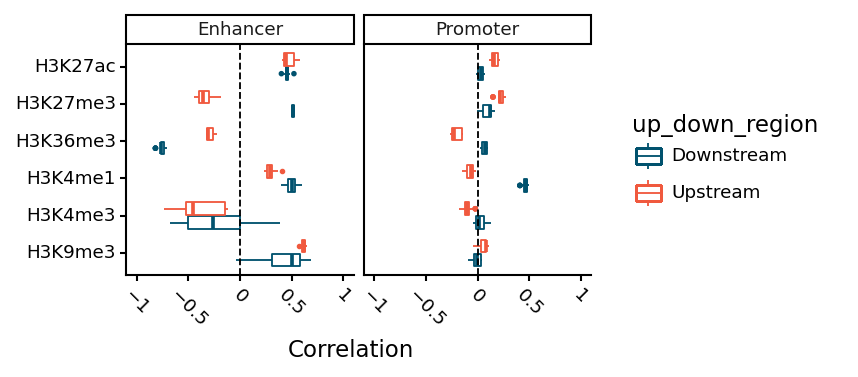

<ggplot: (1458424174070)>

In [130]:
ax = (
    ggplot(
        corr_df,
        aes(x='feat_name', y='r', color='up_down_region'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + geom_hline(aes(yintercept=0), linetype='dashed')
    + coord_flip()
    + facet_wrap('enhan_prom')
    + labs(x=None, y='Correlation')
    + ylim(-1, 1)
    + theme_classic()
    + theme(
        figure_size=(4, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_K562_hm_shap_corr_mean.pdf')

---
# Human H1 histone marks: load data

In [3]:
organism = 'human_h1'
feat_type = 'histone_modifications'
feat_names = [
    'H3K27ac',
    'H3K27me3',
    'H3K36me3',
    'H3K4me1',
    'H3K4me3',
    'H3K9me3'
]

h1_perm_df = pd.read_csv('tables/SupplementalTable_H1_TGI.csv')
h1_tfs = h1_perm_df.loc[h1_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

hm_shap_df = pd.DataFrame()

for feat_name in feat_names:
    print('Working on', feat_name)
    
    hm_shap_subdf = link_shap_to_coord_feats(
        feat_type, h1_tfs,
        '../OUTPUT/human_h1/all_feats/',
        '../RESOURCES/Human_H1_TFPert/TGI_GRCh38_pertResp_DESeq_long.csv',
        is_resp_format_long=True,
        feat_name=feat_name,
        coord_offset=2000, bin_width=100
    )
    hm_shap_subdf['feat_name'] = FEATURE_NAME_DICT[organism][feat_type + ':' + feat_name]
    hm_shap_subdf = hm_shap_subdf[['feat_name', 'tf', 'coord', 'input', 'shap']]
    hm_shap_df = hm_shap_df.append(hm_shap_subdf, ignore_index=True)
    
hm_shap_df.loc[hm_shap_df['coord'] == 2000, 'coord'] = -9999
hm_shap_df.loc[hm_shap_df['coord'] == 2100, 'coord'] = 9999

Working on H3K27ac
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Working on H3K27me3
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Working on H3K36me3
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Working on H3K4me1
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Working on H3K4me3
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Working on H3K9me3
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 


# Human H1 histone marks: global importance

In [4]:
hm_shap_df['abs_shap'] = hm_shap_df['shap'].abs()
hm_shap_df['is_upstream'] = hm_shap_df['coord'].apply(lambda x: True if x < 0 else False)

global_imp_df = hm_shap_df.groupby(
    ['feat_name', 'is_upstream', 'tf']
)[['abs_shap']].mean().reset_index()
global_imp_df['up_down_region'] = global_imp_df['is_upstream'].apply(lambda x: 'Upstream' if x else 'Downstream')

global_imp_df.to_csv('helper_data/human_h1_hm_global_imp_df.csv.gz', index=False)

H3K9me3: t-test p=0.000, Wilcoxon p=0.000
H3K4me3: t-test p=0.000, Wilcoxon p=0.000
H3K4me1: t-test p=0.000, Wilcoxon p=0.000
H3K36me3: t-test p=0.033, Wilcoxon p=0.096
H3K27me3: t-test p=0.000, Wilcoxon p=0.000
H3K27ac: t-test p=0.000, Wilcoxon p=0.000


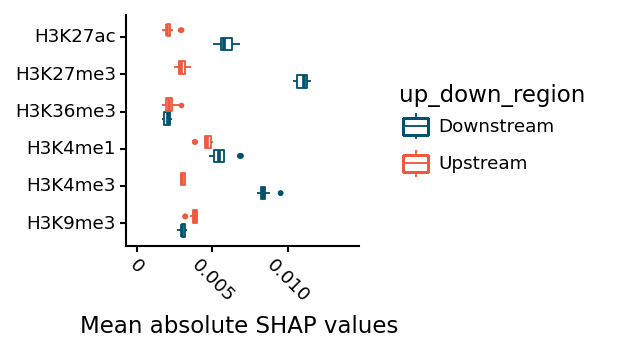

<ggplot: (1458486945021)>

In [119]:
# global_imp_df = pd.read_csv('helper_data/human_h1_hm_global_imp_df.csv.gz')

global_imp_df['feat_name'] = pd.Categorical(global_imp_df['feat_name'], ordered=True, categories=sorted(global_imp_df['feat_name'].unique())[::-1])
global_imp_df['up_down_region'] = pd.Categorical(global_imp_df['up_down_region'], ordered=True, categories=['Downstream', 'Upstream'])

for hm, subdf in global_imp_df.groupby('feat_name'):
    _, t_p = ss.ttest_rel(
        subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
        subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
    _, w_p = ss.wilcoxon(
        subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
        subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
    print('{}: t-test p={:.3f}, Wilcoxon p={:.3f}'.format(hm, t_p, w_p))

ax = (
    ggplot(global_imp_df, aes(x='feat_name', y='abs_shap', color='up_down_region'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + coord_flip()
    + labs(x=None, y='Mean absolute SHAP values')
    + ylim(0, .014)
    + theme_classic()
    + theme(
        figure_size=(2, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_H1_hm_global_imp_vs_up_down_region.pdf')

# Human H1 histone marks: SHAP vs input correlation

In [6]:
corr_df = hm_shap_df.groupby(
    ['feat_name', 'coord', 'tf']
).apply(
    lambda x: ss.pearsonr(x['input'], x['shap'])[0]
).reset_index().rename(columns={0: 'r'})

corr_df.to_csv('helper_data/human_h1_hm_corr_df.csv.gz', index=False)

In [131]:
# corr_df = pd.read_csv('helper_data/human_h1_hm_corr_df.csv.gz')

corr_df['up_down_region'] = corr_df['coord'].apply(lambda x: 'Upstream' if x < 0 else 'Downstream')
corr_df['enhan_prom'] = corr_df['coord'].apply(lambda x: 'Enhancer' if x in [-9999, 9999] else 'Promoter')

# Take the mean across up/downstream bins for each TF
corr_df = corr_df.groupby(['feat_name', 'tf', 'up_down_region', 'enhan_prom'])[['r']].mean().reset_index()

corr_df['feat_name'] = pd.Categorical(corr_df['feat_name'], ordered=True, categories=sorted(corr_df['feat_name'].unique())[::-1])
corr_df['up_down_region'] = pd.Categorical(corr_df['up_down_region'], ordered=True, categories=['Downstream', 'Upstream'])

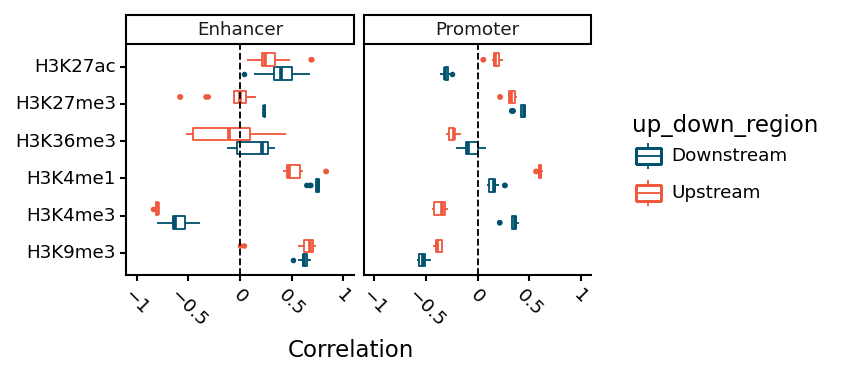

<ggplot: (-9223370578367492678)>

In [132]:
ax = (
    ggplot(
        corr_df,
        aes(x='feat_name', y='r', color='up_down_region'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + geom_hline(aes(yintercept=0), linetype='dashed')
    + coord_flip()
    + facet_wrap('enhan_prom')
    + labs(x=None, y='Correlation')
    + ylim(-1, 1)
    + theme_classic()
    + theme(
        figure_size=(4, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_H1_hm_shap_corr_mean.pdf')

---
# Human HEK293 histone marks: load data

In [ ]:
organism = 'human_hek293'
feat_type = 'histone_modifications'
feat_names = [
    'H3K27ac',
    'H3K27me3',
    'H3K36me3',
    'H3K4me1',
    'H3K4me3',
    'H3K9me3'
]

hek293_perm_df = pd.read_csv('tables/SupplementalTable_HEK293.csv')
hek293_tfs = hek293_perm_df.loc[hek293_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

hm_shap_df = pd.DataFrame()

for feat_name in feat_names:
    print('Working on', feat_name)
    
    hm_shap_subdf = link_shap_to_coord_feats(
        feat_type, hek293_tfs,
        '../OUTPUT/human_hek293/all_feats/',
        '../RESOURCES/Human_HEK293_TFPert/GSE76495_OE_log2FC_long.csv',
        is_resp_format_long=True,
        feat_name=feat_name,
        coord_offset=2000, bin_width=100
    )
    hm_shap_subdf['feat_name'] = FEATURE_NAME_DICT[organism][feat_type + ':' + feat_name]
    hm_shap_subdf = hm_shap_subdf[['feat_name', 'tf', 'coord', 'input', 'shap']]
    hm_shap_df = hm_shap_df.append(hm_shap_subdf, ignore_index=True)
    
hm_shap_df.loc[hm_shap_df['coord'] == 2000, 'coord'] = -9999
hm_shap_df.loc[hm_shap_df['coord'] == 2100, 'coord'] = 9999

# Human HEK293 histone marks: global importance

In [ ]:
hm_shap_df['abs_shap'] = hm_shap_df['shap'].abs()
hm_shap_df['is_upstream'] = hm_shap_df['coord'].apply(lambda x: True if x < 0 else False)

global_imp_df = hm_shap_df.groupby(
    ['feat_name', 'is_upstream', 'tf']
)[['abs_shap']].mean().reset_index()
global_imp_df['up_down_region'] = global_imp_df['is_upstream'].apply(lambda x: 'Upstream' if x else 'Downstream')

global_imp_df.to_csv('helper_data/human_hek293_hm_global_imp_df.csv.gz', index=False)

In [ ]:
# global_imp_df = pd.read_csv('helper_data/human_hek293_hm_global_imp_df.csv.gz')

global_imp_df['feat_name'] = pd.Categorical(global_imp_df['feat_name'], ordered=True, categories=sorted(global_imp_df['feat_name'].unique())[::-1])
global_imp_df['up_down_region'] = pd.Categorical(global_imp_df['up_down_region'], ordered=True, categories=['Downstream', 'Upstream'])

for hm, subdf in global_imp_df.groupby('feat_name'):
    _, t_p = ss.ttest_rel(
        subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
        subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
    _, w_p = ss.wilcoxon(
        subdf.loc[subdf['up_down_region'] == 'Upstream'].sort_values('tf')['abs_shap'].values, 
        subdf.loc[subdf['up_down_region'] == 'Downstream'].sort_values('tf')['abs_shap'].values)
    print('{}: t-test p={:.3f}, Wilcoxon p={:.3f}'.format(hm, t_p, w_p))

ax = (
    ggplot(global_imp_df, aes(x='feat_name', y='abs_shap', color='up_down_region'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + coord_flip()
    + labs(x=None, y='Mean absolute SHAP values')
    + ylim(0, .014)
    + theme_classic()
    + theme(
        figure_size=(2, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_HEK293_hm_global_imp_vs_up_down_region.pdf')

# Human HEK293 histone marks: SHAP vs input correlation

In [ ]:
corr_df = hm_shap_df.groupby(
    ['feat_name', 'coord', 'tf']
).apply(
    lambda x: ss.pearsonr(x['input'], x['shap'])[0]
).reset_index().rename(columns={0: 'r'})

corr_df.to_csv('helper_data/human_hek293_hm_corr_df.csv.gz', index=False)

In [ ]:
# corr_df = pd.read_csv('helper_data/human_hek293_hm_corr_df.csv.gz')

corr_df['up_down_region'] = corr_df['coord'].apply(lambda x: 'Upstream' if x < 0 else 'Downstream')
corr_df['enhan_prom'] = corr_df['coord'].apply(lambda x: 'Enhancer' if x in [-9999, 9999] else 'Promoter')

# Take the mean across up/downstream bins for each TF
corr_df = corr_df.groupby(['feat_name', 'tf', 'up_down_region', 'enhan_prom'])[['r']].mean().reset_index()

corr_df['feat_name'] = pd.Categorical(corr_df['feat_name'], ordered=True, categories=sorted(corr_df['feat_name'].unique())[::-1])
corr_df['up_down_region'] = pd.Categorical(corr_df['up_down_region'], ordered=True, categories=['Downstream', 'Upstream'])

In [ ]:
ax = (
    ggplot(
        corr_df,
        aes(x='feat_name', y='r', color='up_down_region'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + geom_hline(aes(yintercept=0), linetype='dashed')
    + coord_flip()
    + facet_wrap('enhan_prom')
    + labs(x=None, y='Correlation')
    + ylim(-1, 1)
    + theme_classic()
    + theme(
        figure_size=(4, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_HEK293_hm_shap_corr_mean.pdf')